## K - Parameter correlations, truncation and nested sampling

Authors: Christoph Weniger

Last updated: 12 May 2023

**Purpose**: Truncating priors while accounting for parameter correlations. (b) Drawing samples from medium-dimensional posteriors.

In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [356]:
import numpy as np
import torch
from torch import nn

import swyft
from swyft.utils import SwyftSimpleSliceSampler
from swyft import LogRatioEstimator_Autoregressive
import scipy.stats.distributions as dist
import pylab as plt

#import pytorch_lightning as pl

torch.set_float32_matmul_precision('medium')
DEVICE = "cuda"

In [357]:
Nt = 10000
ME = 20
Ns1 = 100
Ns2 = 3000
D = 10
SIGMA = 0.05
NBINS = D*10

In [358]:
class Sim(swyft.Simulator):
    def __init__(self, sampler = None, D = 10, nbins = 100, sigma = 0.1):
        super().__init__()
        self.transform_samples = swyft.to_numpy32
        self.sampler = sampler
        self.sample_z = swyft.RectBoundSampler([dist.uniform(-np.ones(D), 2*np.ones(D))])
        self.D = D
        self.nbins = nbins
        self.sigma = sigma
        
    def m(self, z):
        g = np.linspace(0, self.D, self.nbins)
        m = np.zeros(self.nbins)
        for i in range(self.D):
            m += z[i] * np.minimum(1, np.maximum(0, g - i))
#            m += z[i] * (g >= i) * (g < i+1)
        return m 
    
    def build(self, graph):
        if self.sampler is None:
            z = graph.node("z", self.sample_z)
        else:
            z = graph.node("z", lambda: self.sampler())
        m = graph.node('m', self.m, z)
        x = graph.node("x", lambda m: m + np.random.randn(self.nbins)*self.sigma, m)

100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 877.10it/s]


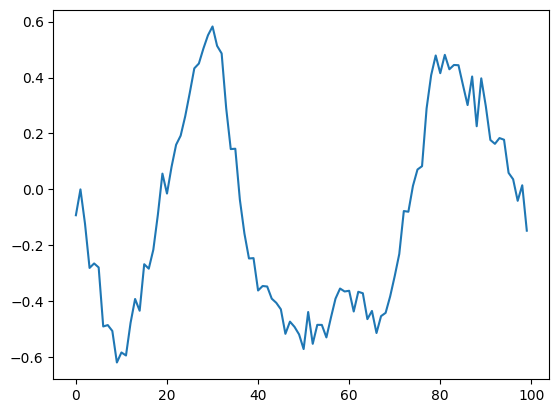

In [307]:
sim = Sim(sigma = SIGMA, D = D, nbins = NBINS)
sample0 = sim.sample(1)[0]
plt.plot(sample0['x'])

In [308]:
resampler = sim.get_resampler("x")

In [309]:
class Network1(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = D):
        super().__init__()

        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.lre = LogRatioEstimator_Autoregressive(D, D, "z", 0.1, 2, 128)
        self.embedding = nn.LazyLinear(D)
        
    def forward(self, A, B):
        x = A["x"]
#        print(A['z'].shape, B['z'].shape)
        f = self.embedding(x)
        result = self.lre(f, A['z'], B['z'])
        return result
    
    
class Network2(swyft.SwyftModule):
    def __init__(self, lr=1e-3, D = D):
        super().__init__()
        self.optimizer_init = swyft.AdamOptimizerInit(lr=1e-3, lrs_factor=0.3, lrs_patience=3)
        self.lre = swyft.LogRatioEstimator_1dim(1, D, "z", 0.1, 128, 3)
        self.embedding = nn.LazyLinear(D)
        
    def forward(self, A, B):
        x = A["x"]
        f = self.embedding(x)
        result = self.lre(f.unsqueeze(-1), B['z'])
        return result

In [ ]:
sim = Sim(sigma = SIGMA, D = D, nbins = NBINS)
samples = sim.sample(Nt)
dm = swyft.SwyftDataModule(samples, fractions = [0.9, 0.1, 0.0], batch_size = 256, on_after_load_sample=resampler)
net1 = Network1()
trainer = swyft.SwyftTrainer(accelerator = "gpu", devices = 1, max_epochs = 100)
trainer.fit(net1, dm)


100%|█████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 3948.56it/s]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                             | Params
---------------------------------------------------------------
0 | lre       | LogRatioEstimator_Autoregressive | 1.4 M 
1 | embedding | LazyLinear                       | 0     
---------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.601     Total estimated model params size (MB)


Epoch 0:  90%|████████████████████████████████████████████████▌     | 36/40 [00:01<00:00, 31.09it/s, loss=-6.95, v_num=29]
Validation: 0it [00:00, ?it/s]
Epoch 1:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 24.81it/s, loss=-8.93, v_num=29, val_loss=2.500]
Validation: 0it [00:00, ?it/s]
Epoch 2:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 26.96it/s, loss=-9.57, v_num=29, val_loss=-8.02]
Validation: 0it [00:00, ?it/s]
Epoch 3:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 32.25it/s, loss=-10.1, v_num=29, val_loss=-8.49]
Validation: 0it [00:00, ?it/s]
Epoch 4:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 32.59it/s, loss=-10.3, v_num=29, val_loss=-9.36]
Validation: 0it [00:00, ?it/s]
Epoch 5:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 30.63it/s, loss=-10.7, v_num=29, val_loss=-10.1]
Validation: 0it [00:00, ?it/s]
Epoch 6:  90%|██████████████████████████████████▏   | 36/40 [00:01<00:00, 29

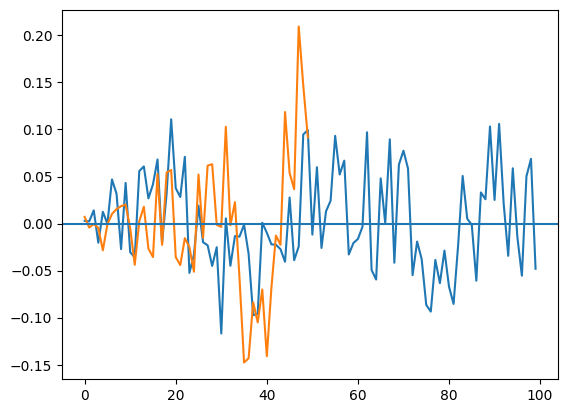

In [317]:
W1 = net1.embedding.weight.cpu().detach()
W2 = net2.embedding.weight.cpu().detach()
for i in [4]:
    plt.plot(W1[i])
    plt.plot(W2[i])
plt.axhline(0)

In [318]:
x0 = torch.tensor(sample0['x'])
def logl1(net, z):
    B = dict(z = z.to(net.device))
    A = dict(x = x0.to(net.device).unsqueeze(0), z = B['z'])
    with torch.no_grad():
        predictions = net1(A, B)
    logl = predictions['lrs_total'].logratios.squeeze(-1)
    return logl#.cpu()

In [349]:
net1.cuda().eval()
X_init = torch.tensor(samples[:1000]["z"]).cuda()
ssss = SwyftSimpleSliceSampler(X_init)
ssss.nested_sampling(lambda z: logl1(net, z), epsilon = 1e-3, logl_th_max = 50);

Z_sum=2.96e+01, Z_rest=3.10e-02, logl_min=33.55:   1%| | 842/100000 [02:42<5:18:


In [350]:
logl_th = ssss.get_threshold(1e-4)
net.cuda().eval()
X_init2, _ = ssss.get_constrained_prior_samples(3000, min_logl = logl_th)
ssss2 = SwyftSimpleSliceSampler(X_init2.cuda())
ssss2.nested_sampling(lambda z: logl1(net, z), epsilon = 1e-3, logl_th_max = 50);

Z_sum=8.46e+10, Z_rest=8.48e+07, logl_min=33.53:   1%| | 556/100000 [01:51<5:31:


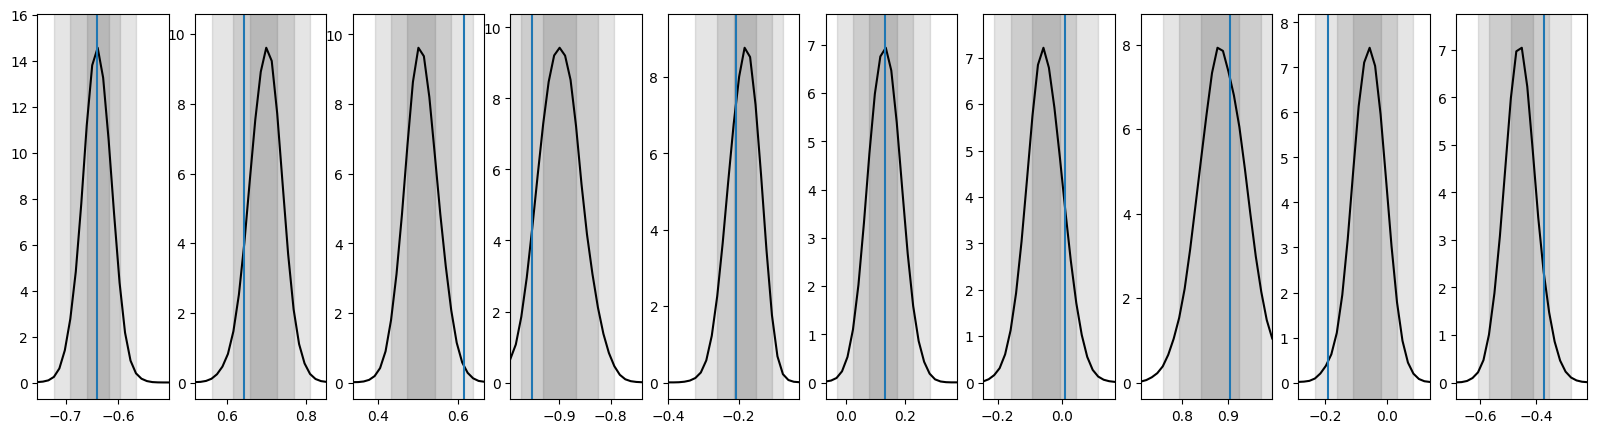

In [352]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
#    plt.xlim([-1, 1])

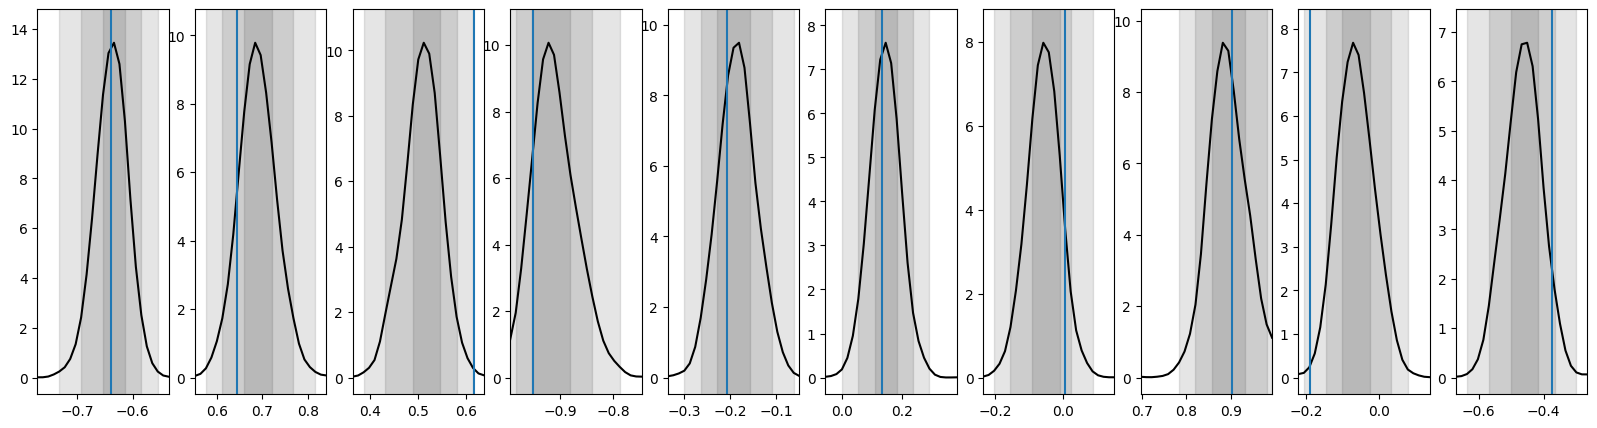

In [348]:
X_post, L_post = ssss.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
#    plt.xlim([-1, 1])

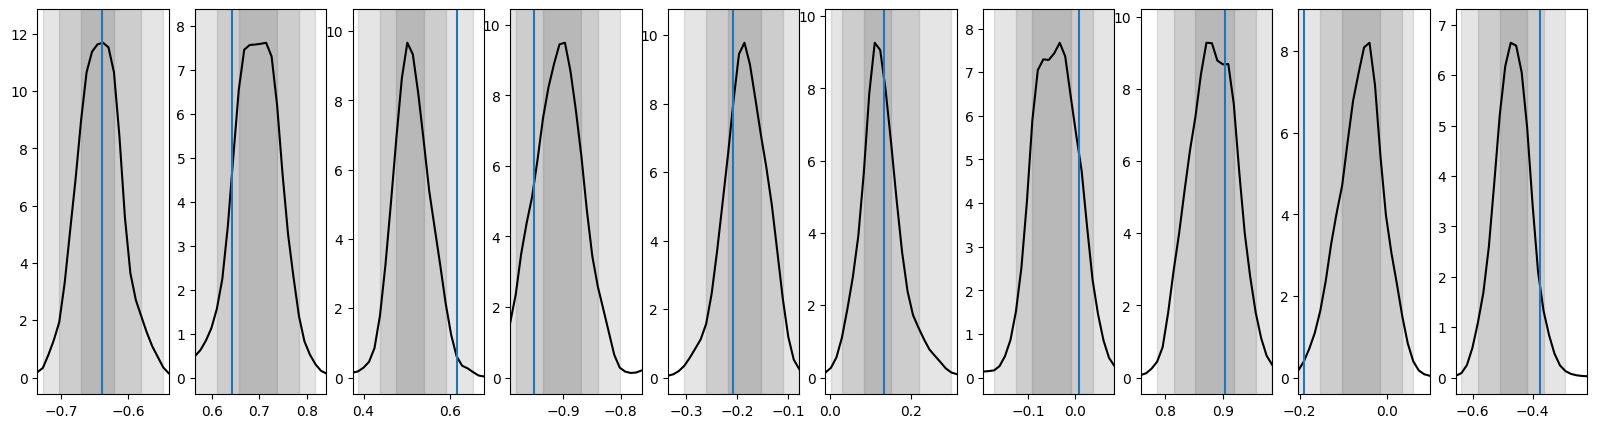

In [347]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
#    plt.xlim([-1, 1])

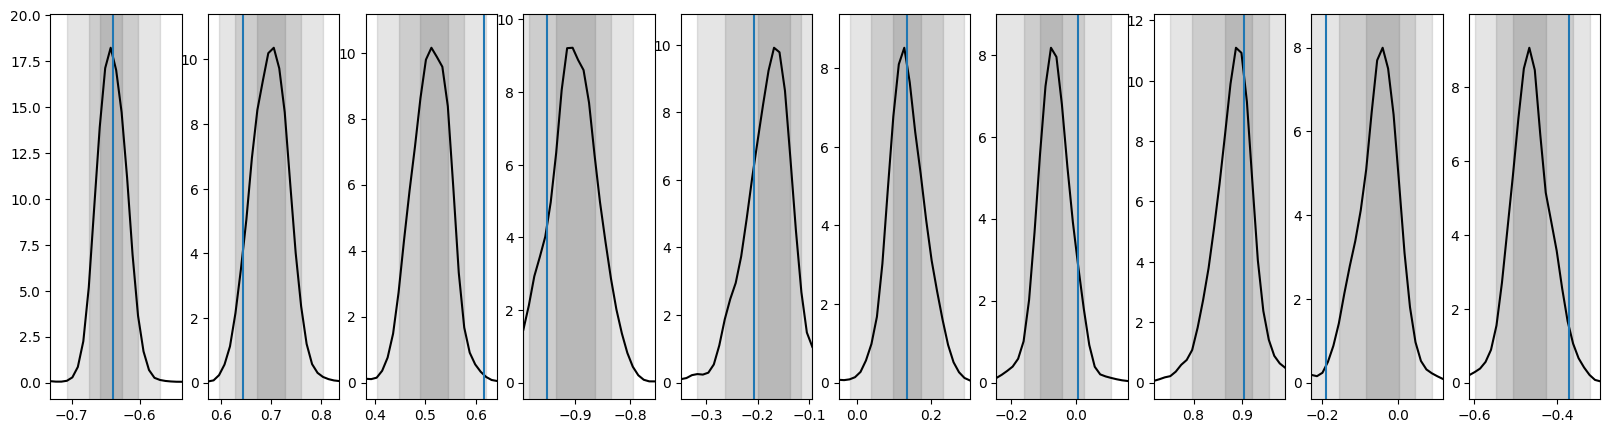

In [344]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
#    plt.xlim([-1, 1])

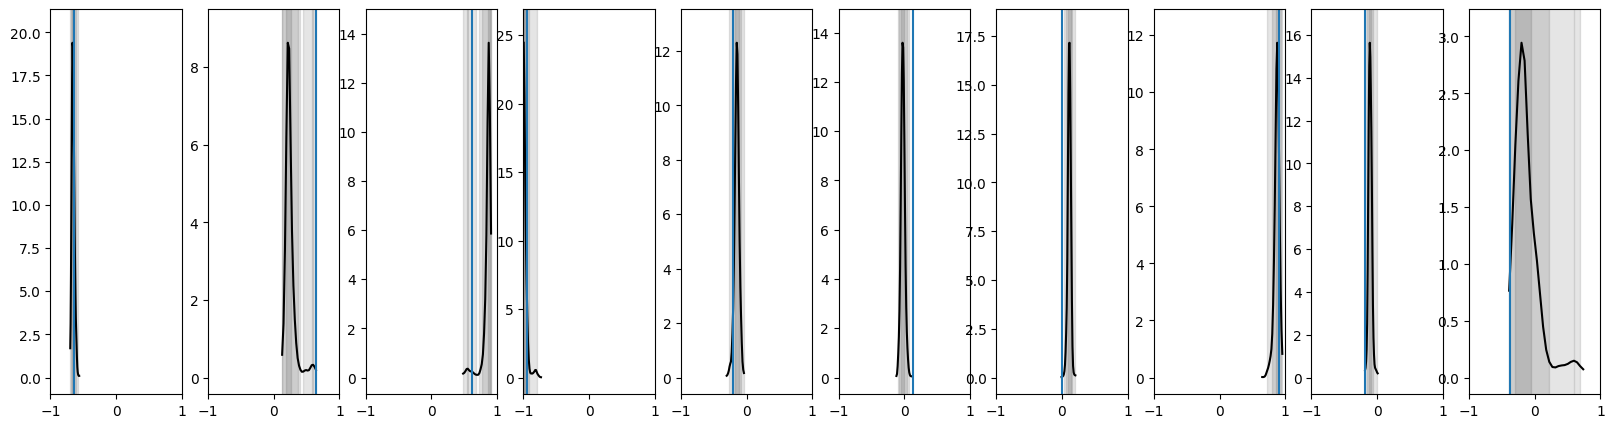

In [339]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
    plt.xlim([-1, 1])

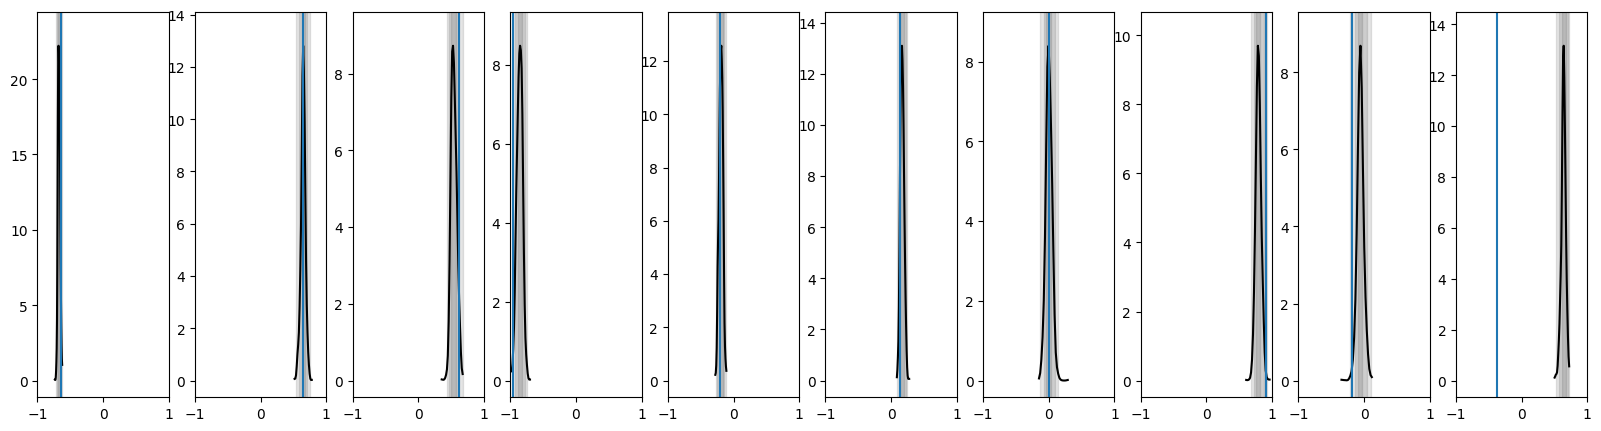

In [333]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
    plt.xlim([-1, 1])

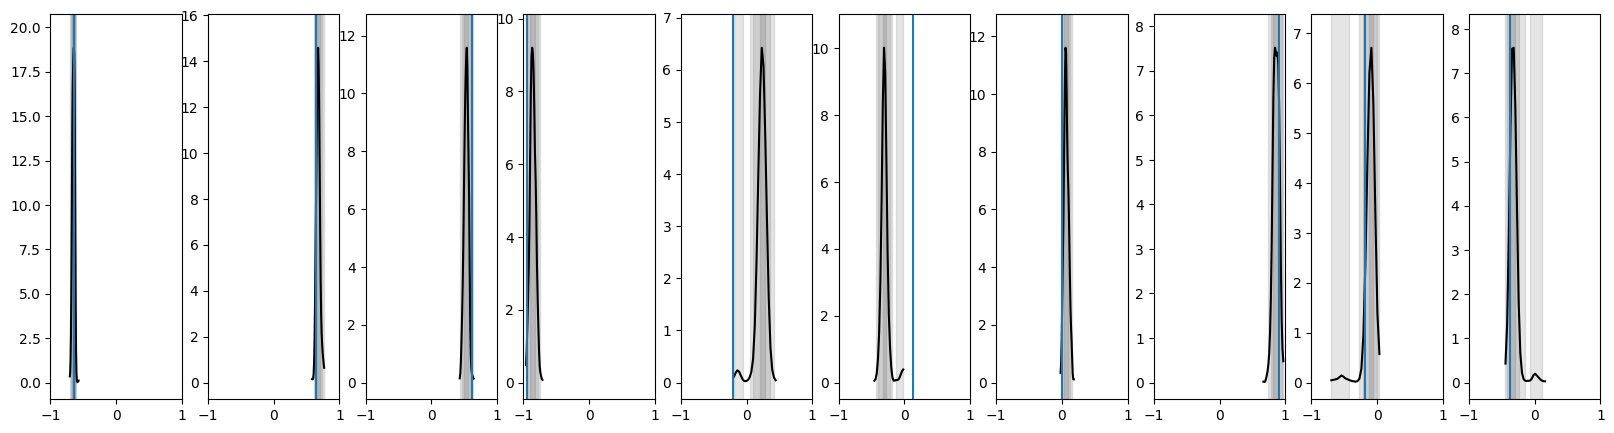

In [329]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
plt.figure(figsize = (20, 5))
for i in range(D):
    plt.subplot(1, D, i+1)
    z0 = sample0['z']
    swyft.plot_1d(lrs2, 'z[%i]'%i, smooth = 1, bins = 25)
    plt.axvline(z0[i])
    plt.xlim([-1, 1])

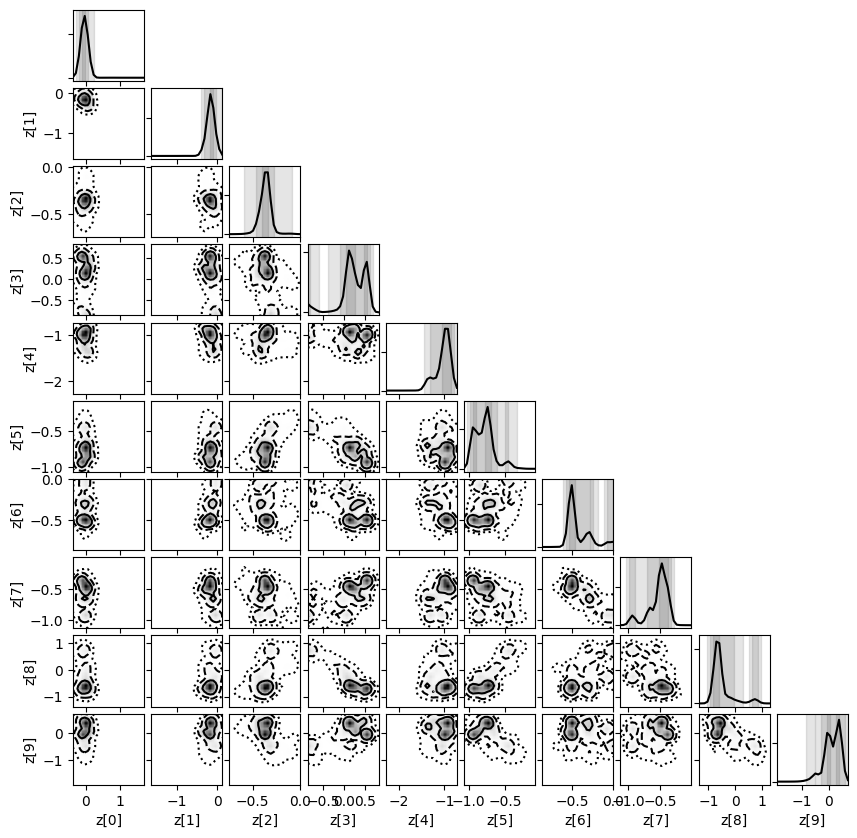

In [99]:
X_post, L_post = ssss2.get_constrained_prior_samples(None, min_logl = logl_th)
lrs = swyft.LogRatioSamples(L_post.unsqueeze(-1), X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))
swyft.corner(lrs, ['z[%i]'%i for i in range(10)], smooth = 1, bins = 25);

In [100]:
X_post, L_post = ssss2.get_posterior_samples()
lrs2 = swyft.LogRatioSamples(L_post.unsqueeze(-1)*0, X_post.unsqueeze(-2), np.array([['z[%i]'%i for i in range(10)]]))

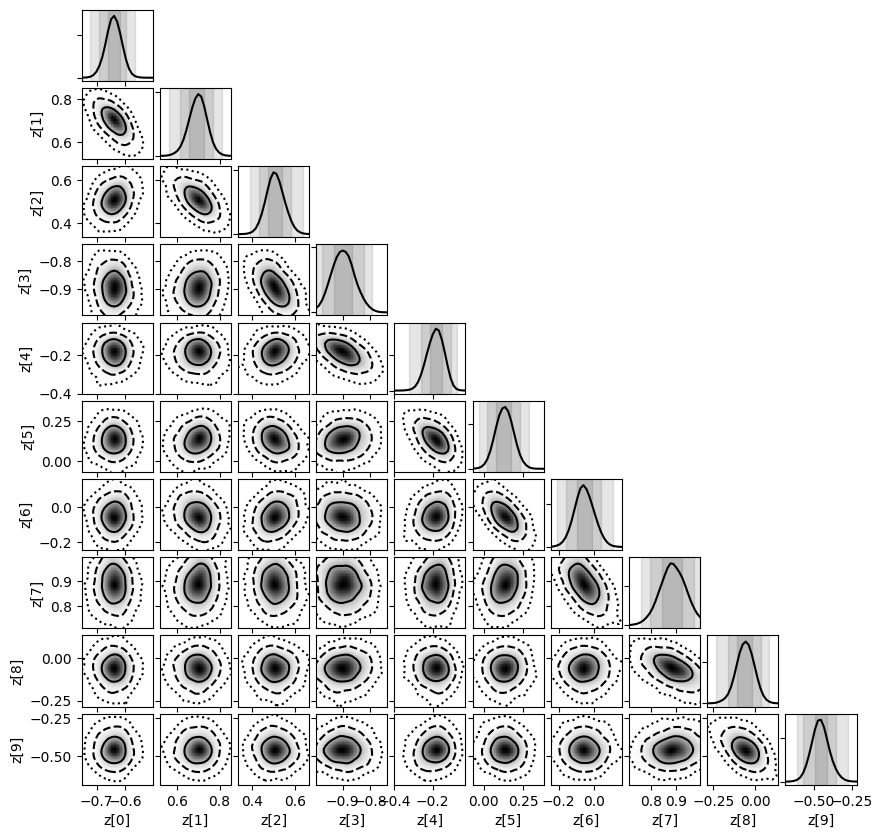

In [353]:
swyft.corner(lrs2, ['z[%i]'%i for i in range(10)], smooth = 1, bins = 25, truth = sample0['z']);